<a href="https://colab.research.google.com/github/baka-onii/OS/blob/main/Another_copy_of_ProjectRitchie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

class StockPredictor:
    def __init__(self, symbol, start, end):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.data = None  # Initialize data as None, then clean it after initialization
        self.clean_data()  # Now, clean_data will properly set self.data

    def calculate_RSI(self, period=14):
        # Calculate the RSI for the given period
        delta = self.data['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(window=period, min_periods=1).mean()
        avg_loss = loss.rolling(window=period, min_periods=1).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_ATR(self, period=14):
        # Calculate the Average True Range (ATR) for the given period
        self.data['High-Low'] = self.data['High'] - self.data['Low']
        self.data['High-PrevClose'] = abs(self.data['High'] - self.data['Close'].shift(1))
        self.data['Low-PrevClose'] = abs(self.data['Low'] - self.data['Close'].shift(1))

        true_range = self.data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
        atr = true_range.rolling(window=period).mean()
        return atr

    def calculate_EMA(self, period=14):
        # Calculate the Exponential Moving Average (EMA) for the given period
        ema = self.data['Close'].ewm(span=period, adjust=False).mean()
        return ema

    def clean_data(self):
        # Load historical data, set index to datetime, and select necessary columns
        df = yf.Ticker(self.symbol).history(start=self.start, end=self.end)
        if df.empty:
            raise ValueError(f"No data found for {self.symbol}.")

        df = df[['Close', 'High', 'Low']]
        df.index = pd.to_datetime(df.index)

        # Set the dataframe to self.data before calculating indicators
        self.data = df

        # Calculate RSI, ATR, and EMA
        self.data['RSI'] = self.calculate_RSI()
        self.data['ATR'] = self.calculate_ATR()
        self.data['EMA'] = self.calculate_EMA()

        # Drop rows with NaN values (from initial periods where indicators can't be calculated)
        self.data.dropna(inplace=True)

    def preprocess_data(self, sequence_length=45):
        # Preprocess data for the LSTM model
        features = ['Close', 'RSI', 'ATR', 'EMA']
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(self.data[features])

        x, y = [], []
        for i in range(sequence_length, len(scaled_data)):
            x.append(scaled_data[i-sequence_length:i, :])  # Use all feature columns
            y.append(scaled_data[i, 0])  # Predict the 'Close' price

        x, y = np.array(x), np.array(y)

        # Split data into training, validation, and test sets (80% train, 10% val, 10% test)
        x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=False)
        x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=False)

        return x_train, y_train, x_val, y_val, x_test, y_test, scaler

    def build_lstm_model(self):
        # Build the LSTM model with multiple layers and dropout
        model = Sequential()
        model.add(LSTM(units=512, return_sequences=True, input_shape=(45, 4)))  # 4 features instead of 1
        model.add(Dropout(0.4))

        model.add(LSTM(units=256, return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(units=128, return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(units=64))
        model.add(Dropout(0.2))

        model.add(Dense(units=32))
        model.add(Dropout(0.2))

        model.add(Dense(units=1))

        # Compile the model with Adam optimizer and MSE loss
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

        return model

    def train_lstm(self, epochs=50, batch_size=32):
        # Train the LSTM model with validation
        x_train, y_train, x_val, y_val, _, _, _ = self.preprocess_data()
        model = self.build_lstm_model()
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(x_val, y_val))

        self.lstm_model = model  # Store the trained model
        self.history = history   # Store the training history

        # Visualize Training and Validation Loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def test_lstm(self):
        # Test the LSTM model on the test data
        x_train, y_train, x_val, y_val, x_test, y_test, scaler = self.preprocess_data()

        # Get predictions for training, validation, and test data
        train_predictions = self.lstm_model.predict(x_train)
        val_predictions = self.lstm_model.predict(x_val)
        test_predictions = self.lstm_model.predict(x_test)

        # We need to inverse-transform the predictions, but MinMaxScaler expects 4 features.
        # Pad the predictions with zeros for the other features (RSI, ATR, EMA).
        pad_train_predictions = np.zeros((train_predictions.shape[0], 4))
        pad_val_predictions = np.zeros((val_predictions.shape[0], 4))
        pad_test_predictions = np.zeros((test_predictions.shape[0], 4))

        pad_train_predictions[:, 0] = train_predictions[:, 0]  # Add predicted Close prices to the first column
        pad_val_predictions[:, 0] = val_predictions[:, 0]
        pad_test_predictions[:, 0] = test_predictions[:, 0]

        # Inverse transform the padded predictions to get original scale
        train_predictions_inv = scaler.inverse_transform(pad_train_predictions)[:, 0]  # Get only 'Close' values
        val_predictions_inv = scaler.inverse_transform(pad_val_predictions)[:, 0]
        test_predictions_inv = scaler.inverse_transform(pad_test_predictions)[:, 0]

        # Inverse transform the actual 'y' values to original scale
        y_train_actual = scaler.inverse_transform(np.pad(y_train.reshape(-1, 1), ((0, 0), (0, 3))))[:, 0]
        y_val_actual = scaler.inverse_transform(np.pad(y_val.reshape(-1, 1), ((0, 0), (0, 3))))[:, 0]
        y_test_actual = scaler.inverse_transform(np.pad(y_test.reshape(-1, 1), ((0, 0), (0, 3))))[:, 0]

        # Visualize the actual vs predicted values for training, validation, and test data
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(y_train_actual, label='Actual Train Data')
        plt.plot(train_predictions_inv, label='Predicted Train Data')
        plt.title('Training Data: Actual vs Predicted')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(y_val_actual, label='Actual Validation Data')
        plt.plot(val_predictions_inv, label='Predicted Validation Data')
        plt.title('Validation Data: Actual vs Predicted')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Visualize the test predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.plot(y_test_actual, label='Actual Test Data', color='blue')
        plt.plot(test_predictions_inv, label='Predicted Test Data', color='red')
        plt.title(f'{self.symbol} Stock Price: Test Data Prediction vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Methods for MACD, Stochastic Oscillator, Bollinger Bands, and Fibonacci Retracement
    def macd(self):
        # MACD calculation
        short_ema = self.data['Close'].ewm(span=12, adjust=False).mean()
        long_ema = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = short_ema - long_ema
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()
        self.data['MACD_Signal'] = np.where(self.data['MACD'] > self.data['Signal_Line'], 1, 0)
        return self.data['MACD_Signal'].iloc[-1]

    def stochastic_oscillator(self, window=14):
        low_min = self.data['Close'].rolling(window=window).min()
        high_max = self.data['Close'].rolling(window=window).max()
        self.data['%K'] = 100 * ((self.data['Close'] - low_min) / (high_max - low_min))
        self.data['%D'] = self.data['%K'].rolling(window=3).mean()
        self.data['Stochastic_Signal'] = np.where(self.data['%K'] > self.data['%D'], 1, 0)
        return self.data['Stochastic_Signal'].iloc[-1]

    def bollinger_bands(self, window=20):
        self.data['MA'] = self.data['Close'].rolling(window=window).mean()
        self.data['BB_Upper'] = self.data['MA'] + (self.data['Close'].rolling(window=window).std() * 2)
        self.data['BB_Lower'] = self.data['MA'] - (self.data['Close'].rolling(window=window).std() * 2)
        self.data['BB_Signal'] = np.where(self.data['Close'] < self.data['BB_Lower'], 1,
                                          np.where(self.data['Close'] > self.data['BB_Upper'], 0, np.nan))
        return self.data['BB_Signal'].dropna().iloc[-1]

    def fibonacci_retracement(self):
        max_price = self.data['Close'].max()
        min_price = self.data['Close'].min()
        diff = max_price - min_price
        levels = {
            'Level_23.6%': max_price - 0.236 * diff,
            'Level_38.2%': max_price - 0.382 * diff,
            'Level_50.0%': max_price - 0.500 * diff,
            'Level_61.8%': max_price - 0.618 * diff,
            'Level_100%': min_price
        }
        current_price = self.data['Close'].iloc[-1]
        if current_price < levels['Level_23.6%']:
            return 1
        elif current_price > levels['Level_61.8%']:
            return 0
        else:
            return np.nan

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0440 - mae: 0.1284 - val_loss: 0.0049 - val_mae: 0.0578
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014 - mae: 0.0282 - val_loss: 0.0035 - val_mae: 0.0462
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.5203e-04 - mae: 0.0209 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.6818e-04 - mae: 0.0174 - val_loss: 0.0037 - val_mae: 0.0482
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 4.5972e-04 - mae: 0.0150 - val_loss: 0.0046 - val_mae: 0.0560
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4.1137e-04 - mae: 0.0141 - val_loss: 0.0042 - val_mae: 0.0518
Epoch 7/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.6859e-04 - mae: 0.0147 - val_loss: 0.0059 - val_mae: 0.0627
Epoch 8/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.8149e-04 - mae: 0.0138 - val_loss: 0.0072 - val_mae: 0.0709
Epoch 9/500
19/19 ━━━━━━━━━━━━━━

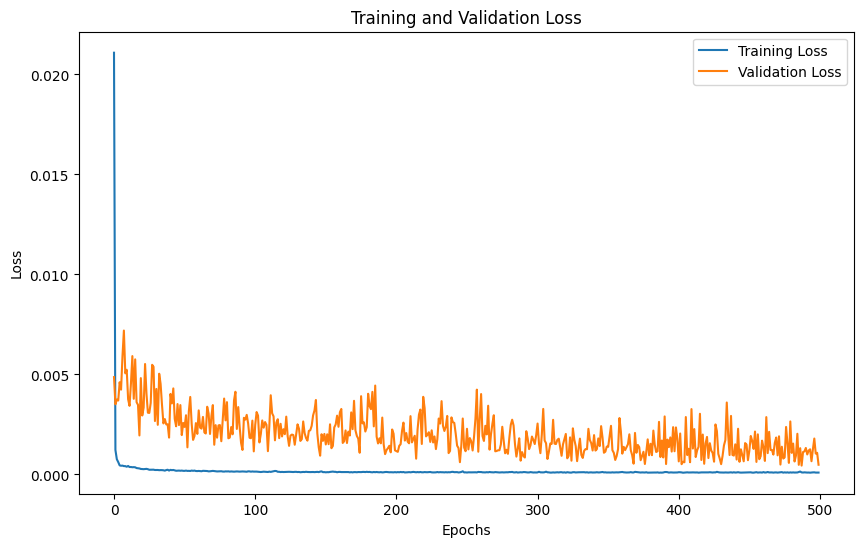

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


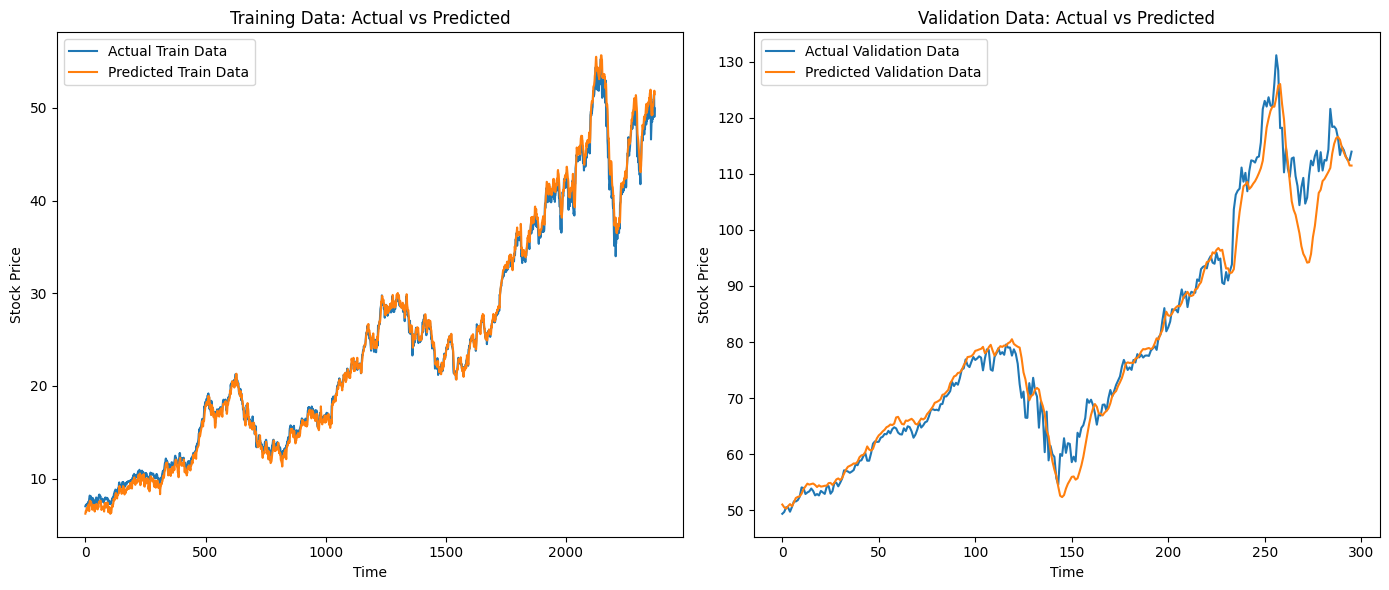

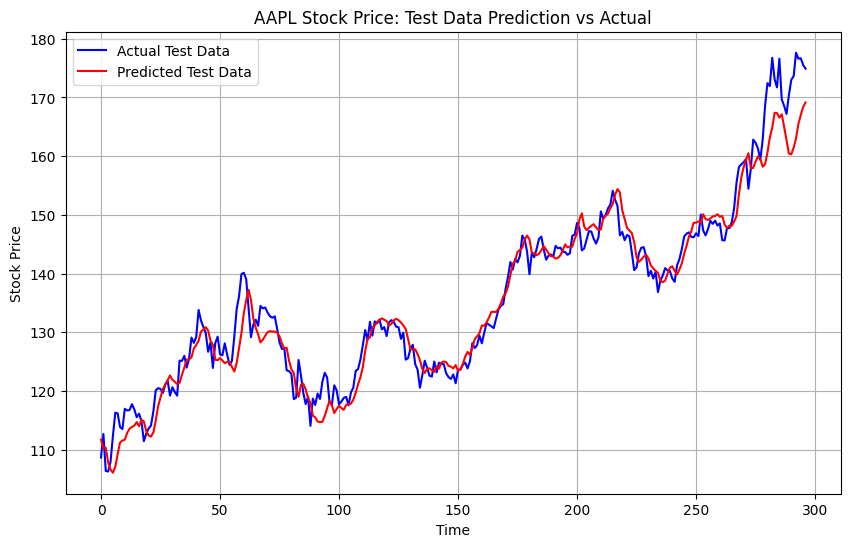

MACD Signal: 0, Stochastic Oscillator Signal: 0, Bollinger Bands Signal: 0.0, Fibonacci Signal: 0


In [ ]:
# symbol = input("Enter the stock symbol: ")
symbol = 'AAPL'
start = '2010-01-01'
end = '2022-01-01'

predictor = StockPredictor(symbol, start, end)

# Train the LSTM model
predictor.train_lstm(epochs=500, batch_size=128)

# Test the LSTM model and visualize the results
predictor.test_lstm()

# Apply previous techniques
macd_signal = predictor.macd()
stochastic_signal = predictor.stochastic_oscillator()
bollinger_signal = predictor.bollinger_bands()
fibonacci_signal = predictor.fibonacci_retracement()

print(f"MACD Signal: {macd_signal}, Stochastic Oscillator Signal: {stochastic_signal}, Bollinger Bands Signal: {bollinger_signal}, Fibonacci Signal: {fibonacci_signal}")